# Plots for Modelling
Plots for Fig 4,5 and 6 of paper. KM data is calculated in this script from the original live-cell imaging dataframe. Fits are provided by Gregory as lines.
see below for path to data

In [13]:
# Load all the packages
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter

#default to overwrite sns settings
plt.style.use('default')
# set text to arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# set font size in pt
font = {'size': 6}
matplotlib.rc('font', **font)
# default linewidth
matplotlib.rcParams['lines.linewidth'] = 1


# conversion factor from mm to inch (matplotlib uses inch)
mm = 1 / 25.4


# functions for data processing
def indicate_first_last(x, column):
    """
    From a series, indicate the if the occurrence is left-, right-, non-censored or both, right and left censored.
    Args:
         x: (pd.Dataframe) dataframe in which one column should be processed
         column: (str) column name from x to be processed
    Returns:
         data: (pd.Dataframe) processed dataframe with an additional column containing the censoring information
    """
    data = x.copy()
    data['censored'] = 'noncensored'
    min_id = data[column].min()
    max_id = data[column].max()
    data.loc[data[column] == min_id, 'censored'] = 'leftcensored'
    data.loc[data[column] == max_id, 'censored'] = 'rightcensored'
    if min_id == max_id:
        data['censored'] = 'nonbursting'
    return data


def signallength(x, column):
    """
    From a series calculate how long a state was present.
    Args:
         x: (pd.Dataframe) dataframe in which one column should be processed
         column: (str) column name from x to be processed
    Returns:
         burst_stats: (pd.Dataframe) processed dataframe
    """
    x = x.assign(signal_no=(x[column] != x[column].shift()).cumsum())
    burst_stats = x.groupby(['unique_id', 'signal_no', column]).agg(
        {'frame': ['count']}).reset_index()
    burst_stats.columns = list(map(''.join, burst_stats.columns.values))
    return burst_stats


def indicate_first_last_series(x, column):
    """
    From a series, indicate the if the occurrence is left-, right-, non-censored or both, right and left censored.
    Args:
         x: (pd.Dataframe) dataframe in which one column should be processed
         column: (str) column name from x to be processed
    Returns:
         data: (pd.Dataframe) processed dataframe with an additional column containing the censoring information
    """
    data = x.copy()
    # indicate groups of values
    data = data.assign(group_no=(data[column] != data[column].shift()).cumsum())
    min_id = data['group_no'].min()
    max_id = data['group_no'].max()
    data['censored'] = 'noncensored'
    data.loc[data['group_no'] == min_id, 'censored'] = 'leftcensored'
    data.loc[data['group_no'] == max_id, 'censored'] = 'rightcensored'
    if min_id == max_id:
        data['censored'] = 'nonbursting'
    data.drop(columns='group_no', inplace=True)
    return data


def overlap_traces_start_average(dataframe, binerized_trace, intensity_trace):
    # get indexes meeting the criterions for overlap
    criteria = dataframe[(dataframe[binerized_trace] == True) & (dataframe['signal_change'] == True)]
    criteria_index = criteria.index
    # make dataframe with all traces
    df_overlay_all = []
    for index in criteria_index:
        selection = dataframe.loc[index - 9:index + 15].reset_index(drop=True)
        cell_id = selection.loc[9, 'unique_id']
        selection.loc[selection['unique_id']!=cell_id, intensity_trace] = np.nan
        selection['group_no'] = (selection[binerized_trace] != selection[binerized_trace].shift()).cumsum()
        groupno_burst = selection['group_no'].iloc[9]
        selection.loc[~selection['group_no'].isin(range(groupno_burst-1,groupno_burst+2)), intensity_trace] = np.nan
        df_overlay_all.append(selection[intensity_trace])
    df_overlay_all = pd.DataFrame(df_overlay_all).transpose()
    # calculate mean and std of the traces
    mean_series = df_overlay_all.mean(axis=1, skipna=True).rename('mean')
    std_series = df_overlay_all.std(axis=1, skipna=True).rename('std')
    return pd.concat([mean_series, std_series], axis=1)


def overlap_traces_start_derivative(dataframe, binerized_trace, intensity_trace):
    # get indexes meeting the criterions for overlap
    criteria = dataframe[(dataframe[binerized_trace] == True) & (dataframe['signal_change'] == True)]
    criteria_index = criteria.index
    # make dataframe with all traces
    df_overlay_all = []
    for index in criteria_index:
        selection = dataframe.loc[index - 9:index + 15].reset_index(drop=True)
        cell_id = selection.loc[9, 'unique_id']
        selection.loc[selection['unique_id'] != cell_id, intensity_trace] = np.nan
        selection['group_no'] = (selection[binerized_trace] != selection[binerized_trace].shift()).cumsum()
        groupno_burst = selection['group_no'].iloc[9]
        selection.loc[
            ~selection['group_no'].isin(range(groupno_burst - 1, groupno_burst + 2)), intensity_trace] = np.nan
        df_overlay_all.append(selection[intensity_trace])
    df_overlay_all = pd.DataFrame(df_overlay_all).transpose()
    df_overlay_all_derivatives = df_overlay_all.diff()

    mean_series = df_overlay_all_derivatives.mean(axis=1).rename('mean')
    std_series = df_overlay_all_derivatives.std(axis=1).rename('std')

    return pd.concat([mean_series, std_series], axis=1)


In [2]:
# Global variables
path_out = '/Users/janatunnermann/Desktop/plots_paper/'

# color scheme
green_5e10 = (111 / 255, 188 / 255, 133 / 255)
blue_5f11 = (113 / 255, 171 / 255, 221 / 255)
purple_5g3 = (156 / 255, 107 / 255, 184 / 255)
red_5g7 = (213 / 255, 87 / 255, 69 / 255)
colors_clones_fit = [green_5e10, blue_5f11, purple_5g3, red_5g7]
clones_fit = ['5E10', '5F11', '5G3', '5G7']

In [3]:
# Load live-cell data and preprocess it to get info on-/off-time length/distribution for KM analysis
# data
path = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/live_imaging/data'
filename = '306KI-ddCTCF-dpuro-MS2-HaloMCP-E10Mobi_JF549_30s_fiveclone_combined_threshold2800_curated.csv'
df_burst = pd.read_csv(os.path.join(path, filename), dtype={'clone': 'str'}, low_memory=False)

# preprocess data
# which datatype to do the calculations with
datatype = 'spotdetected_filtered_curated'

df_burst = df_burst[df_burst['frame'] >= 120]
df_burst = df_burst[df_burst['frame'] <= 600]
df_burst = df_burst[df_burst[datatype].notna()]

# sum-up length of states
df_signallength = [signallength(df_burst[df_burst['unique_id'] == i], column=datatype) for i in
                   df_burst['unique_id'].unique()]
df_signallength = pd.concat(df_signallength, ignore_index=True)
df_signallength['clone'] = df_signallength['unique_id'].map(df_burst.groupby(['unique_id'])['clone'].first())

# Indicate which values are incomplete/censored
df_signallength = [indicate_first_last(df_signallength[df_signallength['unique_id'] == i], column='signal_no') for i in
                   df_signallength['unique_id'].unique()]
df_signallength = pd.concat(df_signallength, ignore_index=True)

# decide on which data to use
# drop left censored
df_signallength = df_signallength[df_signallength.censored != 'leftcensored']
# keep right censored and non-censored
df_signallength.loc[df_signallength['censored'] == 'rightcensored', 'censored'] = 0
df_signallength.loc[df_signallength['censored'] == 'noncensored', 'censored'] = 1
# Either drop or keep non bursting
df_signallength = df_signallength[df_signallength.censored != 'nonbursting']

# Figure 4 Plots

In [5]:
# function that creates either 1,2 or 3 exponential fits based on given parameters
def oneexponential(t, T1):
    return np.exp(-t / T1)


def twoexponential(t, T1, T2, f):
    return f * np.exp(-t / T1) + (1 - f) * np.exp(-t / T2)


def threeexponential(t, T1, T2, T3, f1, f2, f3):
    return f1 * np.exp(-t / T1) + f2 * np.exp(-t / T2) + f3 * np.exp(-t / T3)

In [0]:
# exponential data
path_exponential = '/Volumes/ggiorget_scratch/Gregory/julia/bursting_manuscript/figures/exponentialfits/off_times/fit_summary'

df_1_exponential = pd.read_csv(os.path.join(path_exponential, 'km_1expfit.csv'))
df_1_exponential.replace(np.inf, 1000, inplace=True)
df_2_exponential = pd.read_csv(os.path.join(path_exponential, 'km_2expfit.csv'))
df_2_exponential.replace(np.inf, 1000, inplace=True)
df_3_exponential = pd.read_csv(os.path.join(path_exponential, 'km_3expfit.csv'))
df_3_exponential.replace(np.inf, 1000, inplace=True)

# Fits from Gregory for 1- or 2-state model
path_fits = '/Volumes/ggiorget_scratch/Gregory/julia/bursting_manuscript/figures/initiationfits/'
df_1state_intensityfit = pd.read_csv(os.path.join(path_fits, '1state_ns_line_intensity_fit.csv'))
df_1state_intensityline = pd.read_csv(os.path.join(path_fits, '1state_ns_line_intensity_data.csv'))
df_1state_survivalon = pd.read_csv(os.path.join(path_fits, '1state_ns_line_survivalOn_fit.csv'))
df_1state_mRNA = pd.read_csv(os.path.join(path_fits, '1state_ns_meannascentRNA.csv'), index_col=False)

df_2state_intensityfit = pd.read_csv(os.path.join(path_fits, '2state_ns_line_intensity_fit.csv'))
df_2state_intensityline = pd.read_csv(os.path.join(path_fits, '2state_ns_line_intensity_data.csv'))
df_2state_survivalon = pd.read_csv(os.path.join(path_fits, '2state_ns_line_survivalOn_fit.csv'))
df_2state_mRNA = pd.read_csv(os.path.join(path_fits, '2tate_ns_meannascentRNA.csv'), index_col=False)

In [8]:
# select Off time data for exponential fits
signal = False
measure = "on" if signal == True else "off"
# chose off times with at least one burst in trace
df_signallength_times = df_signallength[df_signallength[datatype] == signal]
df_signallength_times = df_signallength_times[df_signallength_times['clone'] == '5G7']

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


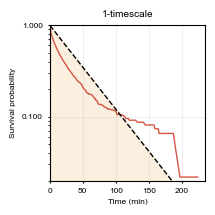

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


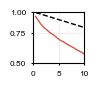

In [16]:
# one exp
result = df_1_exponential.loc[df_1_exponential['clone'] == '5G7']
T1 = result['time'].values[0]

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(50*mm, 50*mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
fit_line = oneexponential(km_times[1:], T1)
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7)
ax.plot(km_times[1:], fit_line, color='black', linestyle='--')
ax.fill_between(km_times[1:], fit_line, y2=0.02, color='antiquewhite', alpha=0.8)
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.ylim(0.02,1)
plt.xlim(0)
plt.title('1-timescale')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'off-times_KM_1expFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# zoom
fig, ax = plt.subplots(figsize=(20*mm, 17*mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
fit_line = oneexponential(km_times[1:], T1)
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7)
ax.plot(km_times[1:], fit_line, color='black', linestyle='--')
plt.yscale('log')
plt.xlim(0, 10)
plt.ylim(0.5,1)
custom_ticks_y = [0.5, 0.75, 1.0]
custom_ticks_x = [0, 5, 10]
# Set custom ticks for y-axis
ax.set_xticks(custom_ticks_x)
ax.set_yticks(custom_ticks_y)
plt.minorticks_off()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)  # Disable scientific notation
formatter.set_useOffset(False)   # Disable offset
ax.yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.01)
plt.savefig(os.path.join(path_out, f'off-times_KM_1expFIT_zoom.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


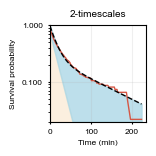

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


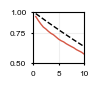

In [11]:
# two exp
result = df_2_exponential.loc[df_2_exponential['clone'] == '5G7']
T1 = result['timeslow'].values[0]
T2 = result['timefast'].values[0]
f = result['pslow'].values[0]

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(50*mm, 50*mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
fit_line = twoexponential(km_times[1:], T1, T2, f)
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7)
ax.plot(km_times[1:], fit_line, color='black', linestyle='--')
exp1 = f*oneexponential(km_times[1:], T1)
exp2 = (1-f)*oneexponential(km_times[1:], T2)
exp2_limit = exp2.copy()
exp2_limit[exp2_limit < 0.02] = 0.02
ax.fill_between(km_times[1:], exp2_limit, 0.02, color='antiquewhite', alpha=0.8)
exp21_limit = exp2+exp1.copy()
exp21_limit[exp21_limit < 0.02] = 0.02
ax.fill_between(km_times[1:], exp21_limit, exp2_limit,  color='lightblue', alpha=0.8)
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.ylim(0.02,1)
plt.xlim(0)
plt.title('2-timescales')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'off-times_KM_2expFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# zoom
fig, ax = plt.subplots(figsize=(20*mm, 17*mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
fit_line = twoexponential(km_times[1:], T1, T2, f)
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7)
ax.plot(km_times[1:], fit_line, color='black', linestyle='--')
plt.yscale('log')
plt.xlim(0, 10)
plt.ylim(0.5,1)
custom_ticks_y = [0.5, 0.75, 1.0]
custom_ticks_x = [0, 5, 10]
# Set custom ticks for y-axis
ax.set_xticks(custom_ticks_x)
ax.set_yticks(custom_ticks_y)
plt.minorticks_off()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)  # Disable scientific notation
formatter.set_useOffset(False)   # Disable offset
ax.yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.01)
plt.savefig(os.path.join(path_out, f'off-times_KM_2expFIT_zoom.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


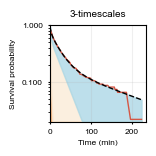

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


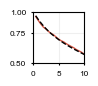

In [12]:
# three exp
result = df_3_exponential.loc[df_3_exponential['clone'] == '5G7']
T1 = result['timeslow'].values[0]
T2 = result['timemiddle'].values[0]
T3 = result['timefast'].values[0]
f1 = result['pslow'].values[0]
f2 = result['pmiddle'].values[0]
f3 = result['pfast'].values[0]

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(50*mm, 50*mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
fit_line = threeexponential(km_times[1:], T1, T2, T3, f1, f2, f3)
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7)
ax.plot(km_times[1:], fit_line, color='black', linestyle='--')
exp1 = f1*oneexponential(km_times[1:], T1)
exp2 = f2*oneexponential(km_times[1:], T2)
exp3 = f3*oneexponential(km_times[1:], T3)
exp3_limit = exp3.copy()
exp3_limit[exp3_limit < 0.02] = 0.02
ax.fill_between(km_times[1:], exp3_limit, y2=.02, color='sandybrown', alpha=0.8)
exp32_limit = exp3+exp2.copy()
exp32_limit[exp32_limit < 0.02] = 0.02
ax.fill_between(km_times[1:], exp32_limit, exp3_limit, color='antiquewhite', alpha=0.8)
exp321_limit = exp3+exp2+exp1.copy()
exp321_limit[exp321_limit < 0.02] = 0.02
ax.fill_between(km_times[1:], exp321_limit, exp32_limit, color='lightblue', alpha=0.8)
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.ylim(0.02,1)
plt.xlim(0)
plt.title('3-timescales')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'off-times_KM_3expFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# zoom
fig, ax = plt.subplots(figsize=(20*mm, 17*mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
fit_line = threeexponential(km_times[1:], T1, T2, T3, f1, f2, f3)
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7)
ax.plot(km_times[1:], fit_line, color='black', linestyle='--')
plt.yscale('log')
plt.xlim(0, 10)
plt.ylim(0.5,1)
custom_ticks_y = [0.5, 0.75, 1.0]
custom_ticks_x = [0, 5, 10]
# Set custom ticks for y-axis
ax.set_xticks(custom_ticks_x)
ax.set_yticks(custom_ticks_y)
plt.minorticks_off()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)  # Disable scientific notation
formatter.set_useOffset(False)   # Disable offset
ax.yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.01)
plt.savefig(os.path.join(path_out, f'off-times_KM_3expFIT_zoom.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [15]:
# calculate df from which the intensity trace overlay is constructed
# indicate the start-time of a signal change (on/off and off/on)
intensity_read_out = 'corr_trace'
df = df_burst.sort_values(['unique_id', 'frame']).reset_index(drop=True)
df['signal_change'] = df.groupby('unique_id').apply(lambda x: x[datatype] != x[datatype].shift()).reset_index(drop=True)
# indicate left and right censored data
df = df.groupby(['unique_id'], group_keys=True).apply(indicate_first_last_series, column=datatype).reset_index(
    drop=True)

# exclude non bursting cells and left-censored bursts
df = df[df['censored'] != 'nonbursting']
df = df[~((df['censored'] == 'leftcensored') & (df[datatype] == True))].reset_index(drop=True)
df = df[~((df['censored'] == 'rightcensored') & (df[datatype] == True))].reset_index(drop=True)

# -- Intensity trace --
# Group the DataFrame by the 'group' column
grouped = df.groupby('clone')
# Apply your function to each group and filter based on the condition
df_overlay_grouped_meanint = []
for name, group in grouped:
    processed_group = overlap_traces_start_average(group, binerized_trace=datatype, intensity_trace=intensity_read_out)
    processed_group['clone'] = name
    df_overlay_grouped_meanint.append(processed_group)
df_overlay_grouped_meanint = pd.concat(df_overlay_grouped_meanint)
clones = df_overlay_grouped_meanint['clone'].unique()

# -- Derivative intensity trace --
grouped = df.groupby('clone')
# Apply your function to each group and filter based on the condition
df_overlay_grouped_drivative = []
for name, group in grouped:
    processed_group = overlap_traces_start_derivative(group, binerized_trace=datatype,
                                                      intensity_trace=intensity_read_out)
    processed_group['clone'] = name
    df_overlay_grouped_drivative.append(processed_group)
df_overlay_grouped_drivative = pd.concat(df_overlay_grouped_drivative)

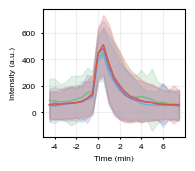

In [19]:
# Intensity trace overlay
fig, ax = plt.subplots(figsize=(45*mm, 39*mm))
for i, clone in enumerate(clones):
    color = colors_clones_fit[i]
    data = df_overlay_grouped_meanint[df_overlay_grouped_meanint['clone'] == clone]
    ax.plot((data.index - 9) / 2, data['mean'], color=color, label=f'{clone}', linewidth=1)
    ax.fill_between((data.index - 9) / 2, data['mean'] - data['std'],
                    data['mean'] + data['std'], color=color, alpha=0.2)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Time (min)')
x_values = np.arange(int(min(data.index - 9) / 2), int(max(data.index - 9) / 2) + 1, 2)
ax.set_xticks(x_values)
ax.set_xticklabels(x_values)
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.1)
limits = ax.get_xlim()
plt.savefig(os.path.join(path_out, 'Intensity-trace_overlay.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

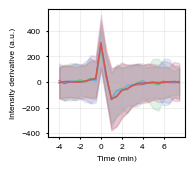

In [20]:
# Derivative intensity trace overlay -> Supplements!
fig, ax = plt.subplots(figsize=(45*mm, 39*mm))
for i, clone in enumerate(clones):
    color = colors_clones_fit[i]
    data = df_overlay_grouped_drivative[df_overlay_grouped_drivative['clone'] == clone]
    ax.plot((data.index - 9) / 2, data['mean'], color=color, label=f'{clone}')
    ax.fill_between((data.index - 9) / 2, data['mean'] - data['std'],
                    data['mean'] + data['std'], color=color, alpha=0.2)
x_values = np.arange(int(min(data.index - 9) / 2), int(max(data.index - 9) / 2) + 1, 2)
ax.set_xticks(x_values)
ax.set_xticklabels(x_values)
plt.xlim(limits)
plt.ylabel('Intensity derivative (a.u.)')
plt.xlabel('Time (min)')
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'Intensity-trace_overlay_derivative.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [21]:
# Fits for 1- or 2-state model
# select a model and do the plotting
Fits = '1state' # '1state' or '2state'
df_fit = df_1state_survivalon if Fits == '1state' else df_2state_survivalon
data_line_int = df_1state_intensityline if Fits == '1state' else df_2state_intensityline
df_fit_int = df_1state_intensityfit if Fits == '1state' else df_2state_intensityfit
df_fit_mRNA = df_1state_mRNA if Fits == '1state' else df_2state_mRNA
df_fit_mRNA = df_fit_mRNA.transpose()
df_fit_mRNA['color'] = [red_5g7] * len(df_fit_mRNA)
df_fit_mRNA.loc['model', 'color'] = 'darkgrey'

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


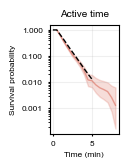

In [24]:
# On Time fit
signal = True
measure = "on" if signal == True else "off"
# chose off times with at least one burst in trace
df_signallength_times = df_signallength[df_signallength[datatype] == signal]
df_signallength_times = df_signallength_times[df_signallength_times['clone'] == '5G7']

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(28 * mm, 1.5))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
km_ci_lower[km_ci_lower == 0] = np.nan
km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
km_ci_upper[km_ci_upper == 0] = np.nan
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7, alpha=0.5)
ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=red_5g7, alpha=0.2)
ax.plot(df_fit['time(frame)'] / 2, df_fit['5G7'], color='black', linestyle='--')
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.title('Active time')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'{measure}-times_KM_{Fits}FIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

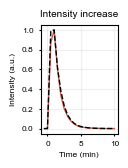

In [25]:
# Intensity fit
fig, ax = plt.subplots(figsize=(28 * mm, 1.5))
ax.plot(data_line_int['time(frame)'] / 2, data_line_int['5G7'], color=red_5g7)
ax.plot(df_fit_int['time(frame)'] / 2, df_fit_int['5G7'], color='black', linestyle='--')
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Time (min)')
plt.title('Intensity increase')
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'Intensity-trace_overlay_{Fits}FIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

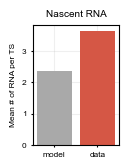

In [26]:
# mRNA fit
fig, ax = plt.subplots(figsize=(28 * mm, 1.5))
plt.bar(df_fit_mRNA.index, df_fit_mRNA[0], color=df_fit_mRNA['color'], zorder=2)
plt.ylabel('Mean # of RNA per TS')
plt.xlabel('')
plt.title('Nascent RNA')
plt.grid(alpha=0.2, zorder=1)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'mean_mRNA_{Fits}.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# Figure 5 Plots

In [27]:
# select data for closest clone 5G7
df_signallength_5g7 = df_signallength[df_signallength['clone'] == '5G7']

In [28]:
# Load data from Gregory, he provided the data in a csv files
path_gregory_fig5 = '/Volumes/ggiorget_scratch/Gregory/julia/bursting_manuscript/figures/3s2r_model_singleclone'

# Off time distribution
df_off_model = pd.read_csv(os.path.join(path_gregory_fig5, 'off_model.csv'))

# On time distribution
df_on_model = pd.read_csv(os.path.join(path_gregory_fig5, 'on_model.csv'))

# Time to next burst
df_next_burst_data = pd.read_csv(os.path.join(path_gregory_fig5, 'nextburst_data.csv'))

df_next_burst_model = pd.read_csv(os.path.join(path_gregory_fig5, 'nextburst_model.csv'))

#Intensity trace
df_intensity_data = pd.read_csv(os.path.join(path_gregory_fig5, 'int_data.csv'))

df_intensity_model = pd.read_csv(os.path.join(path_gregory_fig5, 'int_model.csv'))

df_fitparameter = pd.read_csv(os.path.join(path_gregory_fig5, 'summary_fit.csv'))
df_fitparameter_5g7 = df_fitparameter[df_fitparameter['clone'] == '5G7']

path_bootstrapped_correlations = '/Volumes/ggiorget_scratch/Jana'
df_correlation_boostrap = pd.read_csv(os.path.join(path_bootstrapped_correlations, 'correlation_bootstrap.csv'))

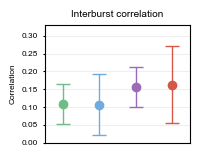

In [29]:
# - Correlation Interburst duration, bootstrapped -
# Adjusted x positions to add extra spacing
category_positions = [-0.5, 0, 1, 2, 3, 3.5]

fig, ax = plt.subplots(figsize=(45 * mm, 35 * mm))
for i, (pos, mean, sd, color) in enumerate(
        zip(category_positions[1:-1], df_correlation_boostrap['corr_off'], df_correlation_boostrap['sd_off'], colors_clones_fit)):
    plt.errorbar(pos, mean, yerr=sd, fmt='o', color=color, capsize=5, label=f'Category {df_correlation_boostrap["clone"][i]}')
ax.set_xticks([])
ax.set_xticklabels([])
# Set x-axis limits to add space at the edges
padding = 0.5  # Adjust the padding value as needed
ax.set_xlim([category_positions[1] - padding, category_positions[-2] + padding])
ax.set_ylim(0, 0.33)
plt.ylabel('Correlation')
plt.title('Interburst correlation')
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'OFF_times_correlation.pdf'), bbox_inches='tight', transparent=True)
plt.show()

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


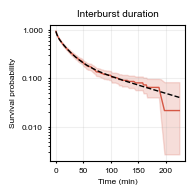

In [30]:
# - Off times -
signal = False
measure = "on" if signal == True else "off"
# chose off times with at least one burst in trace
df_signallength_times = df_signallength_5g7[df_signallength_5g7[datatype] == signal]

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(45 * mm, 45 * mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
km_ci_lower[km_ci_lower == 0] = np.nan
km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
km_ci_upper[km_ci_upper == 0] = np.nan
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7, linewidth=1)
ax.plot(df_off_model['time(frame)'], df_off_model['5G7'], color='black', linestyle='--')
ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=red_5g7, alpha=0.2)
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.title('Interburst duration')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'3s2r_model_5G7-offtimes.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


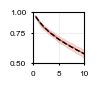

In [31]:
# Off times zoom
fig, ax = plt.subplots(figsize=(20 * mm, 17 * mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
km_ci_lower[km_ci_lower == 0] = np.nan
km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
km_ci_upper[km_ci_upper == 0] = np.nan
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7)
ax.plot(df_off_model['time(frame)'], df_off_model['5G7'], color='black', linestyle='--')
ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=red_5g7, alpha=0.2)
plt.yscale('log')
plt.xlim(0, 10)
plt.ylim(0.5, 1)
custom_ticks_y = [0.5, 0.75, 1.0]
custom_ticks_x = [0, 5, 10]
# Set custom ticks for y-axis
ax.set_xticks(custom_ticks_x)
ax.set_yticks(custom_ticks_y)
plt.minorticks_off()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)  # Disable scientific notation
formatter.set_useOffset(False)  # Disable offset
ax.yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.01)
plt.savefig(os.path.join(path_out, f'3s2r_model_5G7-offtimes_zoom.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


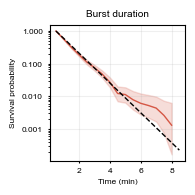

In [32]:
# - On times -
signal = True
measure = "on" if signal == True else "off"
# chose off times with at least one burst in trace
df_signallength_times = df_signallength_5g7[df_signallength_5g7[datatype] == signal]

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(45 * mm, 45 * mm))
kmf.fit((df_signallength_times['framecount'] / 2), event_observed=df_signallength_times['censored'])
km_times = kmf.survival_function_.index.values
km_survival_probs = kmf.survival_function_['KM_estimate'].values
km_survival_probs[km_survival_probs == 0] = np.nan
km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
km_ci_lower[km_ci_lower == 0] = np.nan
km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
km_ci_upper[km_ci_upper == 0] = np.nan
ax.plot(km_times[1:], km_survival_probs[1:], color=red_5g7, linewidth=1)
ax.plot(df_on_model['time(frame)'], df_on_model['5G7'], color='black', linestyle='--')
ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=red_5g7, alpha=0.2)
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.title('Burst duration')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'3s2r_model_5G7-ontimes.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

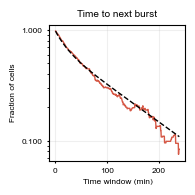

In [33]:
# - Time to next burst -
fig, ax = plt.subplots(figsize=(45 * mm, 45 * mm))
ax.plot(df_next_burst_data['time(frame)'], df_next_burst_data['5G7'], color=red_5g7)
ax.plot(df_next_burst_model['time(frame)'], df_next_burst_model['5G7'], color='black', linestyle='--')
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time window (min)')
plt.ylabel('Fraction of cells')
plt.title('Time to next burst')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'3s2r_model_5G7-nextburst.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

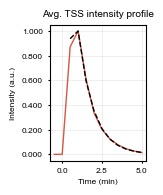

In [34]:
# - Intensity trace -
fig, ax = plt.subplots(figsize=(35 * mm, 45 * mm))
ax.plot(df_intensity_data['time(frame)'], df_intensity_data['5G7'], color=red_5g7)
ax.plot(df_intensity_model['time(frame)'], df_intensity_model['5G7'], color='black', linestyle='--')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Intensity (a.u.)')
plt.title('Avg. TSS intensity profile')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'3s2r_model_5G7-inttrace.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

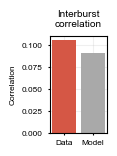

In [35]:
# Interburst correlation
fig, ax = plt.subplots(figsize=(24 * mm, 35 * mm))
ax.bar([0, 1], [df_fitparameter_5g7['corr_data'].values[0], df_fitparameter_5g7['corr_model'].values[0]],
       color=[red_5g7, 'darkgrey'], zorder=2)
plt.ylabel('Correlation')
plt.title('Interburst correlation')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Data'] + ['Model'])
plt.grid(alpha=0.2, zorder=0)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.ylabel('Correlation')
plt.title('Interburst\ncorrelation')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'interburstcorrelation_5G7.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

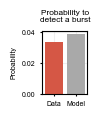

In [35]:
# Burst probability
fig, ax = plt.subplots(figsize=(24 * mm, 35 * mm))
ax.bar([0, 1], [df_fitparameter_5g7['pburst_data'].values[0], df_fitparameter_5g7['pburst_model'].values[0]],
       color=[red_5g7, 'darkgrey'], zorder=2)
plt.ylabel('Correlation')
plt.title('Interburst correlation')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Data'] + ['Model'])
plt.grid(alpha=0.2, zorder=0)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.ylabel('Probability')
plt.title('Probability to\ndetect a burst')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'Burstprob_5G7.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# Figure 6 Plots

In [52]:
# Load data from Gregory, he provided the data in a csv files
path_gregory_fig6 = '/Volumes/ggiorget_scratch/Gregory/julia/bursting_manuscript/figures/3s2r_model_allclones'
path_gregory_fig5 = '/Volumes/ggiorget_scratch/Gregory/julia/bursting_manuscript/figures/3s2r_model_singleclone'
# Off time distribution
df_off_allclones_model = pd.read_csv(os.path.join(path_gregory_fig6, 'off_model.csv'))

# On time distribution
df_on_allclones_model = pd.read_csv(os.path.join(path_gregory_fig6, 'on_model.csv'))

# Time to next burst
df_next_burst_allclones_data = pd.read_csv(os.path.join(path_gregory_fig6, 'nextburst_data.csv'))

df_next_burst_allclones_model = pd.read_csv(os.path.join(path_gregory_fig6, 'nextburst_model.csv'))

df_fitparameter = pd.read_csv(os.path.join(path_gregory_fig5, 'summary_fit.csv'))

df_kforward = pd.read_csv(os.path.join(path_gregory_fig6, 'datakforward.csv'))
df_kforward['clone'] = ['5G7', '5G3', '5F11', '5E10']
colors_clones_fit_reverse = colors_clones_fit[::-1]
df_kforward['color'] = colors_clones_fit_reverse

trendline = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/trendline_zuinetal.csv'
df_trendline = pd.read_csv(trendline, header=None)

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert t

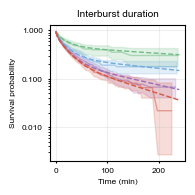

In [53]:
# - Off times -
signal = False
measure = "on" if signal == True else "off"
# chose off times with at least one burst in trace
df_signallength_times = df_signallength[df_signallength[datatype] == signal]

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(45*mm, 45*mm))
for color_id, clone in enumerate(clones_fit):
    kmf.fit((df_signallength_times[(df_signallength_times['clone'] == clone)]['framecount']/2),
            event_observed=df_signallength_times[(df_signallength_times['clone'] == clone)]['censored'],
            label=clone)
    km_times = kmf.survival_function_.index.values
    km_survival_probs = kmf.survival_function_[clone].values
    km_survival_probs[km_survival_probs == 0] = np.nan
    km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
    km_ci_lower[km_ci_lower == 0] = np.nan
    km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
    km_ci_upper[km_ci_upper == 0] = np.nan
    ax.plot(km_times[1:], km_survival_probs[1:], color=colors_clones_fit[color_id], label=clone, alpha = 0.5)
    ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=colors_clones_fit[color_id], alpha=0.2)
    ax.plot(df_off_allclones_model['time(frame)'], df_off_allclones_model[clone], color=colors_clones_fit[color_id], linestyle='--')
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.title('Interburst duration')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'{measure}-times_KM_modelFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert t

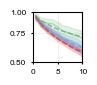

In [54]:
# - Off times zoom -
signal = False
measure = "on" if signal == True else "off"
# chose off times with at least one burst in trace
df_signallength_times = df_signallength[df_signallength[datatype] == signal]

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(20 * mm, 17 * mm))
for color_id, clone in enumerate(clones_fit):
    kmf.fit((df_signallength_times[(df_signallength_times['clone'] == clone)]['framecount']/2),
            event_observed=df_signallength_times[(df_signallength_times['clone'] == clone)]['censored'],
            label=clone)
    km_times = kmf.survival_function_.index.values
    km_survival_probs = kmf.survival_function_[clone].values
    km_survival_probs[km_survival_probs == 0] = np.nan
    km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
    km_ci_lower[km_ci_lower == 0] = np.nan
    km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
    km_ci_upper[km_ci_upper == 0] = np.nan
    ax.plot(km_times[1:], km_survival_probs[1:], color=colors_clones_fit[color_id], label=clone, alpha = 0.5, zorder=2)
    ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=colors_clones_fit[color_id], alpha=0.2, zorder=1)
    ax.plot(df_off_allclones_model['time(frame)'], df_off_allclones_model[clone], color=colors_clones_fit[color_id], linestyle='--', zorder=3)
plt.yscale('log')
plt.xlim(0, 10)
plt.ylim(0.5, 1)
custom_ticks_y = [0.5, 0.75, 1.0]
custom_ticks_x = [0, 5, 10]
# Set custom ticks for y-axis
ax.set_xticks(custom_ticks_x)
ax.set_yticks(custom_ticks_y)
plt.minorticks_off()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)  # Disable scientific notation
formatter.set_useOffset(False)  # Disable offset
ax.yaxis.set_major_formatter(formatter)
plt.grid(alpha=0.2, zorder=0)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'{measure}-times_KM_modelFIT_zoom.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert t

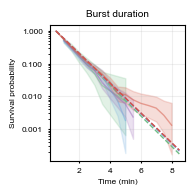

In [55]:
# # - On times -
signal = True
measure = "on" if signal == True else "off"
# chose off times with at least one burst in trace
df_signallength_times = df_signallength[df_signallength[datatype] == signal]

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(45*mm, 45*mm))
for color_id, clone in enumerate(clones_fit):
    kmf.fit((df_signallength_times[(df_signallength_times['clone'] == clone)]['framecount']/2),
            event_observed=df_signallength_times[(df_signallength_times['clone'] == clone)]['censored'],
            label=clone)
    km_times = kmf.survival_function_.index.values
    km_survival_probs = kmf.survival_function_[clone].values
    km_survival_probs[km_survival_probs == 0] = np.nan
    km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
    km_ci_lower[km_ci_lower == 0] = np.nan
    km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
    km_ci_upper[km_ci_upper == 0] = np.nan
    ax.plot(km_times[1:], km_survival_probs[1:], color=colors_clones_fit[color_id], label=clone, alpha = 0.5)
    ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=colors_clones_fit[color_id], alpha=0.2)
    ax.plot(df_on_allclones_model['time(frame)'][0:17], df_on_allclones_model[clone][0:17], color=colors_clones_fit[color_id], linestyle='--')
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.title('Burst duration')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'{measure}-times_KM_modelFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

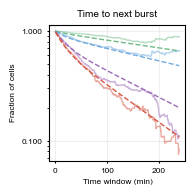

In [56]:
# - Time to next burst -
fig, ax = plt.subplots(figsize=(45 * mm, 45 * mm))
for color_id, clone in enumerate(clones_fit):
    ax.plot(df_next_burst_allclones_data['time(frame)']/2, df_next_burst_allclones_data[clone], color=colors_clones_fit[color_id], alpha = 0.5)
    ax.plot(df_next_burst_allclones_model['time(frame)'], df_next_burst_allclones_model[clone], color=colors_clones_fit[color_id], linestyle='--')
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Time window (min)')
plt.ylabel('Fraction of cells')
plt.title('Time to next burst')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'nextburst_modelFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

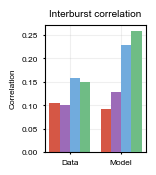

In [57]:
# Interburst correlation

# Define bar width
bar_width = 1
# Create x values for separation of data, model groups
x = np.arange(len(df_fitparameter['clone']))

fig, ax = plt.subplots(figsize=(35 * mm, 40 * mm))
# Plot the data bars (on the left data, right model)
ax.bar(x, df_fitparameter['corr_data'], width=bar_width, label='Data', color=list(reversed(colors_clones_fit)), zorder=2)
ax.bar(x + len(x)+ bar_width, df_fitparameter['corr_model'], width=bar_width, label='Model', color=list(reversed(colors_clones_fit)), zorder=3)
# Set x-ticks to center of the grouped bars
ax.set_xticks([np.mean(x), np.mean(x + len(x) + bar_width)])
ax.set_xticklabels(['Data'] + ['Model'])
plt.grid(alpha=0.2, zorder=0)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.ylabel('Correlation')
plt.title('Interburst correlation')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'interburstcorrelation_modelFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

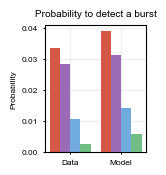

In [58]:
# Probability to detect a burst

# Define bar width
bar_width = 1
# Create x values for separation of data, model groups
x = np.arange(len(df_fitparameter['clone']))

fig, ax = plt.subplots(figsize=(35 * mm, 40 * mm))
# Plot the data bars (on the left data, right model)
ax.bar(x, df_fitparameter['pburst_data'], width=bar_width, label='Data', color=list(reversed(colors_clones_fit)), zorder=2)
ax.bar(x + len(x)+ bar_width, df_fitparameter['pburst_model'], width=bar_width, label='Model', color=list(reversed(colors_clones_fit)), zorder=3)
# Set x-ticks to center of the grouped bars
ax.set_xticks([np.mean(x), np.mean(x + len(x) + bar_width)])
ax.set_xticklabels(['Data'] + ['Model'])
plt.grid(alpha=0.2, zorder=0)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.ylabel('Probability')
plt.title('Probability to detect a burst')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'burstprobability_modelFIT.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

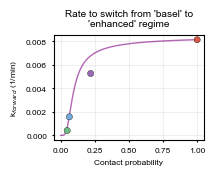

In [59]:
# Plot burst frequency with trendline
# scale trend-line to min and max value from my experiment (maybe fit instead?)
df_trendline_scaled = df_trendline.copy()
min_value, min_cp = 0, 0
max_value, max_cp = df_kforward.loc[df_kforward['clone'] == '5G7', ['kforward', 'cp']].values[0]
min_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0, df_trendline_scaled.columns[1]].values[0]
max_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0.99, df_trendline_scaled.columns[1]].values[0]
m = (max_value - min_value) / (max_original - min_original)
b = min_value - m * min_original
df_trendline_scaled['y_scaled'] = m * df_trendline_scaled.iloc[:, 1] + b

# plot cv burst frequency
plt.figure(figsize=(50*mm, 40*mm))
plt.scatter(df_kforward['cp'], df_kforward['kforward'], color=df_kforward['color'], edgecolor ='black', linewidths=0.25, zorder=3, s=20)
plt.plot(df_trendline_scaled[0], df_trendline_scaled['y_scaled'], color='purple', alpha=0.6, linewidth=1, zorder=2)
plt.grid(alpha=0.2, zorder=1)
plt.xlabel('Contact probability')
plt.ylabel('k$_{forward}$ (1/min)')
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.title('Rate to switch from \'basel\' to\n\'enhanced\' regime')
plt.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'kforward_cp.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()